# Discretizing 2d Helmholtz with PML absorbing boundaries

In this notebook, we discretize the 2d Helmholtz equation
$$
(-\nabla^2 - \omega^2 \varepsilon) u = b
$$
in a box $L_x \times L_y$ domain with [PML absorbing boundary layers](https://arxiv.org/abs/2108.05348), with an arbitrary non-constant coefficient $\varepsilon(x,y)>0$.

This is equivalent to the 2d time-harmonic Maxwell eqjuations for the $u = E_z$ polarization, where $\varepsilon$ is the relative permittivity (the dielectric constant), $\omega$ is the frequency, and the speed of light $c = 1$ (natural units), and $b = i\omega J$ is proportional to the electric current density.

In [1]:
using SparseArrays

## 1d case:

To start with, we'll do the simple 1d case for $x\in [0,L]$, where the parameter `ε` is an arbitrary function `ε(x)` returning the dielectric constant at each point.

`dpml` is the thickness of the PML absorbing layers — this is appended to the computational cell on both sides, so we actually get $x \in [-\text{dpml}, L+\text{dpml}]$.  `Rpml` is the "theoretical" or "round-trip" reflection of the PML — what we would get in the limit of infinite resolution, typically set to a small number.  `resolution` is the number of grid points per unit distance.

The return value is the tuple `A, x`, where `A` is the sparse matrix representing the discretized operator, and `x` is the array of $x$ coordinates at the grid points:

In [2]:
function Maxwell1d(L, ε, ω; dpml=2, resolution=20, Rpml=1e-20)
    # PML σ = σ₀ x², with σ₀ chosen so that the round-trip reflection is Rpml
    σ₀ = -log(Rpml) / (4dpml^3/3)
    
    M = round(Int, (L+2dpml) * resolution)
    dx = (L+2dpml) / (M+1)
    x = (1:M) * dx # x grid
    
    # 1st-derivative matrix
    o = ones(M)/dx
    D = spdiagm(M+1,M, -1 => -o, 0 => o)
    
    # need PML scale factors 1/(1+iσ/ω) at x and x' points
    σ = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > L+dpml ? σ₀*(ξ-(L+dpml))^2 : 0.0 for ξ in x]
    Σ = spdiagm(@. inv(1 + (im/ω)*σ))
    x′ = ((0:M) .+ 0.5).*dx # 1st-derivative grid points
    σ′ = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > L+dpml ? σ₀*(ξ-(L+dpml))^2 : 0.0 for ξ in x′]
    Σ′ = spdiagm(@. inv(1 + (im/ω)*σ′))
    
    x = x .- dpml
    return Σ * D' * Σ′ * D - spdiagm(ω^2 * complex.(ε.(x))), x
end

Maxwell1d (generic function with 1 method)

Now, let's solve an example problem where our right-hand side "current source" $b$ is a "delta function" point source in the center.

For fun, we will include non-constant coefficients $\varepsilon$ which $=1$ in most of the domain but $=5$ in the region $x \in [12,12.1]$.  This will cause an interference pattern to be set up in the higher-$\varepsilon$ layer.

We pass $2\pi$ for $\omega = 2\pi/\lambda$ (in $c=1$ units), corresponding to a wavelength of $\lambda = 1$ in the $\varepsilon=1$ regions.  (The spatial wavelength is $\lambda/\sqrt{\varepsilon}$.) 

In [3]:
L = 20
A, x = Maxwell1d(L,x -> 12 ≤ x ≤ 12.1 ? 5 : 1,2π, resolution=1000, dpml=2);

In [4]:
using PyPlot

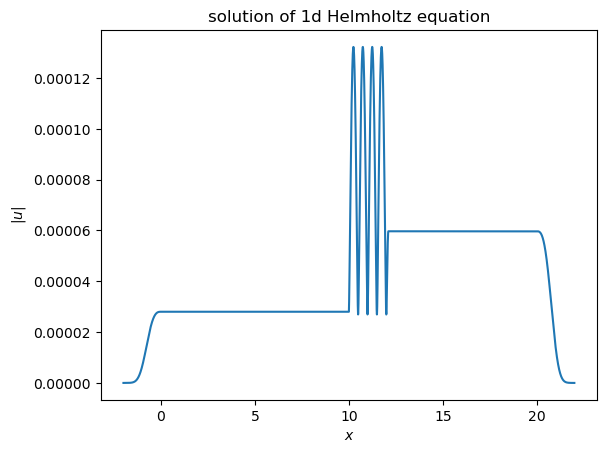

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/stevenj/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(28.0, 0.5, '$|u|$')

In [5]:
M = length(x)
b = zeros(M)
b[M÷2] = 1
u = A \ b
plot(x, abs.(u))
title("solution of 1d Helmholtz equation")
xlabel(L"x")
ylabel(L"|u|")

## 2d case:

Now let's do the 2d case.  Same idea, but now for $(x,y) \in [0,L_x] \times [0,L_y]$ plus PML boundaries on all sides with thickness `dpml` (in both x and y).

Basically, it is just a tensor product of 1d discretizations, converted to matrix form as Kronecker products:

In [6]:
function Maxwell2d(Lx, Ly, ε, ω; dpml=2, resolution=20, Rpml=1e-20)
    # PML σ = σ₀ x²/dpml², with σ₀ chosen so that the round-trip reflection is Rpml
    σ₀ = -log(Rpml) / (4dpml/3)
    
    M = round(Int, (Lx+2dpml) * resolution)
    N = round(Int, (Ly+2dpml) * resolution)
    dx = (Lx+2dpml) / (M+1)
    dy = (Ly+2dpml) / (N+1)
    x = (1:M) * dx # x grid
    y = (1:N) * dy # y grid
    x′ = @. ((0:M) + 0.5)*dx # 1st-derivative grid points
    y′ = @. ((0:N) + 0.5)*dy
    
    # 1st-derivative matrices
    ox = ones(M)/dx
    oy = ones(N)/dy
    Dx = spdiagm(M+1,M, -1 => -ox, 0 => ox)
    Dy = spdiagm(N+1,N, -1 => -oy, 0 => oy)
    
    # PML complex "stretch" factors 1/(1+iσ/ω) at both x and x' points:
    σx = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Lx+dpml ? σ₀*(ξ-(Lx+dpml))^2 : 0.0 for ξ in x]
    Σx = spdiagm(@. inv(1 + (im/ω)*σx))
    σx′ = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Lx+dpml ? σ₀*(ξ-(Lx+dpml))^2 : 0.0 for ξ in x′]
    Σx′ = spdiagm(@. inv(1 + (im/ω)*σx′))
    # similarly for y and y':
    σy = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Ly+dpml ? σ₀*(ξ-(Ly+dpml))^2 : 0.0 for ξ in y]
    Σy = spdiagm(@. inv(1 + (im/ω)*σy))
    σy′ = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Ly+dpml ? σ₀*(ξ-(Ly+dpml))^2 : 0.0 for ξ in y′]
    Σy′ = spdiagm(@. inv(1 + (im/ω)*σy′))
    
    # stretched 2nd-derivative matrices
    D2x = Σx * Dx' * Σx′ * Dx
    D2y = Σy * Dy' * Σy′ * Dy
    
    # combine x and y with Kronecker products
    Ix = spdiagm(ones(M))
    Iy = spdiagm(ones(N))
    x = x .- dpml
    y = y .- dpml
    return (kron(Ix, D2y) + kron(D2x, Iy) -
            spdiagm(vec([ω^2 * ε(ξ, ζ) for ζ in y, ξ in x])),
            x, y)
end

Maxwell2d (generic function with 1 method)

Again, we'll try an example problem with a point source in a $20\times 20$ cell, this time with $\varepsilon=1$ everywhere, so that we see a cylindrical wave (converging to a Hankel function at infinite resolution) radiating away from the point source.

In [7]:
A, x, y = Maxwell2d(20, 20, (x,y) -> 1, 2π);

In [8]:
M, N = length(x), length(y)
b = zeros(N,M)
b[N÷4, M÷2] = 1
u = reshape(A \ vec(b), N,M);

Note, by the way:

In [9]:
size(A)

(230400, 230400)

Thanks to sparse matrices, we can solve a $230400 \times 230400$ system of equations in a second or so!

Let's plot the real part of the solution nicely using a diverging color scale

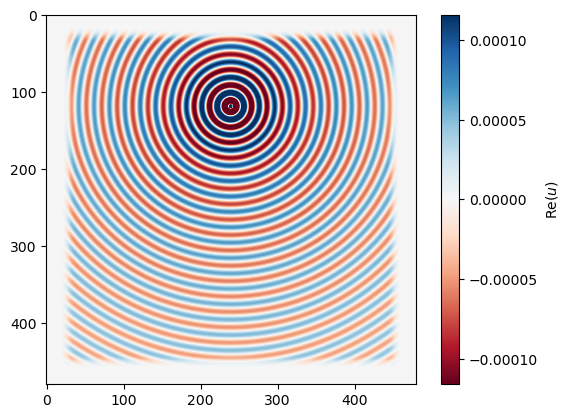

PyObject <matplotlib.colorbar.Colorbar object at 0x16b1b6ac0>

In [10]:
scale = maximum(abs, real(u)) / 10
imshow(real(u), cmap="RdBu", vmin=-scale, vmax=scale)
colorbar(label=L"\operatorname{Re}(u)")

Notice how nicely circular the wavefronts are — any "rippling" would indicate interference from boundary reflections, but we implemented PML properly so it is doing a good job.